In [1]:
# regular expressions
import re 

# math and data utilities
import numpy as np
import pandas as pd
import scipy.stats as ss
import itertools

# data and statistics libraries
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set-up default visualization parameters
mpl.rcParams['figure.figsize'] = [10,6]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

# Initial Setup
We can download the data from Kaggle to our data folder using the command line:

`kaggle competitions download -c titanic`

`unzip titanic.zip`

After that, let's get the data into some Pandas dataframes:

In [2]:
train_df = pd.read_csv('data/train.csv', index_col='PassengerId')
test_df = pd.read_csv('data/test.csv', index_col='PassengerId')

# Exploratory Data Analysis:

Our next step will be to ask and answer the following questions:

1. _Are we missing any data?_ 
2. _What form does our data take?_
3. _What additional information can we garner from what we already have?_
4. _What relationships can we find between our variables, especially between the input and output variables?_ 
5. _How can we use the answers to the first two question to add value to our data and the models that will use it?_


## Question 1: Missing Data
Let's take a look at the number of entries in our training data, as well as those variables contain significant missing data. Below, we see that the training data contains 891 passenger samples, with 11 total variables describing each passenger. We see that there is a significant amount of missing data for the variables __Age__ and __Cabin__. We will have to deal with this missing data by either finding an intelligent way to fill the gaps, or perhaps dropping the features entirely. 

In [3]:
# Question 1: Are we missing any data?
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Question 2: What is the form of our data:
Taking a look at our `.info()` print out as well as the first few entries of our data frame below, we see that our data comes primarily in the form of categorical data, with the exception of __Age__ and __Fare__. These categories are described by Python strings, which is why the data type above is listed as 'object'. This is how Pandas deals with unidentified data types. We will later tell Pandas that these variables are strings. 

In [4]:
# Look at the first few entries
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Question 3: What additional information can we garner from what we already have?

### Passenger Title
 
A quick glance at the __Name__ variable shows us that each name comes with a title. A title is useful in telling us things like social status, marriage status career, and even rank within a specific career. Therefore, it may be useful to have this information on hand. Let's parse it out:

In [5]:
train_df['Title'] = train_df['Name'].str.extract(r'([A-Za-z]+)\.')
train_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Don           1
Capt          1
Sir           1
Jonkheer      1
Countess      1
Mme           1
Ms            1
Lady          1
Name: Title, dtype: int64

Next, we might notice that many of these titles are synonymous. For example, _Mme_ is the French equivalent to  'Mrs' and _Mlle_ is the equivalent to  'Miss'. Other titles imply varying levels of nobility like 'Sir', 'Countess' and 'Don'. Some titles infer a profession. Let's reduce our titles to their common denominators:

In [6]:
title_dict = {
    'Mrs': 'Mrs', 'Lady': 'Lady', 'Countess': 'Lady',
    'Jonkheer': 'Lord', 'Col': 'Officer', 'Rev': 'Rev',
    'Miss': 'Miss', 'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Dona': 'Lady',
    'Mr': 'Mr', 'Dr': 'Dr', 'Major': 'Officer', 'Capt': 'Officer', 'Sir': 'Lord', 'Don': 'Lord', 'Master': 'Master'
}

train_df.Title = train_df.Title.map(title_dict)

Text(0.5, 1.0, 'Histogram of Categorical Data: Title')

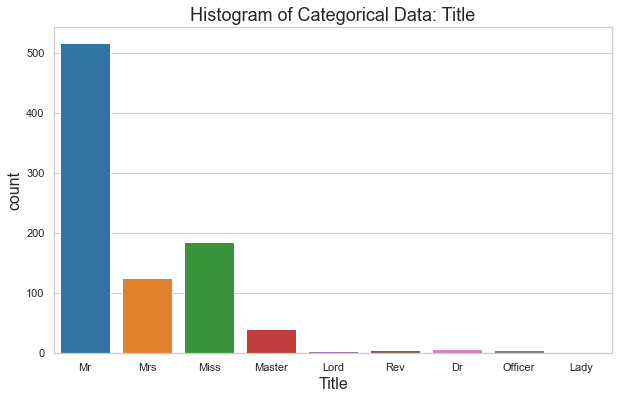

In [7]:
sns.countplot(train_df.Title).set_title("Histogram of Categorical Data: Title")

In [8]:
train_df.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr


By again looking at our data set, we might notice the variables __SibSp__ and __Parch__. The first is the number of siblings and/or spouses that a passenger traveled with. The second is the number of parents and/or children a passenger traveled with. Combining these two variables we can get total family size. 

In [9]:
train_df['FamilySize'] = 1 + train_df.SibSp + train_df.Parch

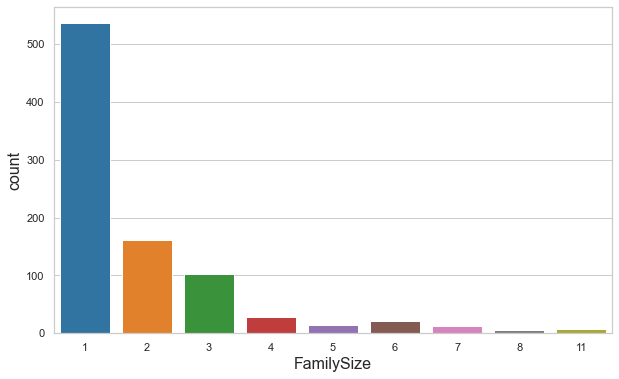

In [10]:
sns.countplot(train_df.FamilySize)

It appears that the Titanic's voyage was not necessarily a couple's or family affair. The majority of passengers traveled alone, and perhaps that is valuable information. Let's add the category __Alone__.

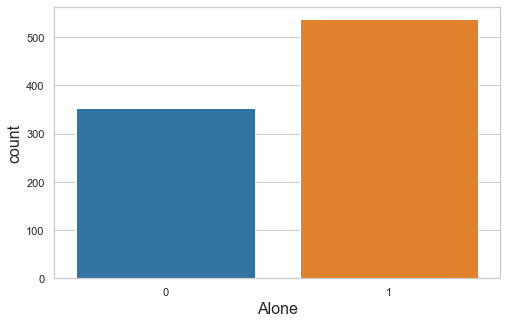

In [11]:
train_df['Alone'] = train_df.FamilySize.apply(lambda x: 1 if x==1 else 0)
plt.figure(figsize=(8,5))
sns.countplot(train_df.Alone)

### Last Name

A last name is a group identity. While we know that many passengers traveled alone, there were still a significant number of families onboard the Titanic. Perhaps survival among specific families was more common than others. This is all speculation, but perhaps worth a look.

In [12]:
train_df['LName'] = train_df.Name.str.extract(r'([A-Za-z]+),')

### Name Length

This one has a very simple explanation: While reviewing notebooks on Kaggle, I saw that one competitor found that the length of a person's name added to the performance of the model. So, why not try it out?

In [13]:
train_df['NameLength'] = train_df.Name.apply(len)
train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Alone,LName,NameLength
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,Braund,23
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,Cumings,51
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,Heikkinen,22
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,Futrelle,44
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,Allen,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,1,1,Montvila,21
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,1,1,Graham,28
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss,4,0,Johnston,40


## Question 4: What statistical relationships does our data contain?

We now have a more robust data set that includes (possibly) valuable new insights into our passengers lives. But how helpful is this data, really? One way to find out is to look at the statistical relationships between our variables, especially between each input variable and our single output variable __Survived__. 

Correlation is a common go-to tool we would use to determine such relationships. However, it is important to note that we have mostly categorical data in our data set, and that throws a small wrench in our gears. 

First, our categorical data needs to be encoded into numeric format before we can do calculations of any kind. 

Next, we need to consider the types categorical we are studying:

- __Ordinal__ variables imply an underlying rank, or order. The classifications mild, moderate, severe would be an example. A common method of calculating the correlation is called _Kendall's Tau ($\tau$)_. 
- __Nominal__ variables have no such rank or order. An example would be Male or Female. In this case we will use _Cramer's V_ correlation.

In [14]:
train_df.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Alone,LName,NameLength
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,2,0,Braund,23


In [15]:
# nominal variables (use Cramer's V)
nom_vars = ['Survived', 'Title', 'Embarked', 'Sex', 'Alone', 'LName']

# ordinal variables (nominal-ordinal, use Rank Biserial or Kendall's Tau)
ord_vars = ['Survived', 'Pclass', 'FamilySize', 'Parch', 'SibSp', 'NameLength']

# continuous variables (use Pearson's r)
cont_vars = ['Survived', 'Fare', 'Age']

In the cell above, we separate our variables by their data types. The reason for this is that when considering the underlying associations between variables, there is not a "one size fits all" method. The most common mathematical method of calculating correlation is _Pearson's r_, which should typically only be used on continuous variables. In our case, the vast majority of variables are actually discrete/categorical. 

In order to perform calculations, we must convert any non numeric data into numbers. Let's get started:

In [16]:
# convert all string 'object' types to numeric categories
for i in train_df.columns:
    if train_df[i].dtype == 'object':
        train_df[i], _ = pd.factorize(train_df[i])

In [17]:
def cramers_v_matrix(dataframe, variables):
    
    df = pd.DataFrame(index=dataframe[variables].columns, columns=dataframe[variables].columns, dtype="float64")
    
    for v1, v2 in itertools.combinations(variables, 2):
        
        # generate contingency table:
        table = pd.crosstab(dataframe[v1], dataframe[v2])
        n     = len(dataframe.index)
        r, k  = table.shape
        
        # calculate chi squared and phi
        chi2  = ss.chi2_contingency(table)[0]
        phi2  = chi2/n
        
        # bias corrections:
        r = r - ((r - 1)**2)/(n - 1)
        k = k - ((k - 1)**2)/(n - 1)
        phi2 = max(0, phi2 - (k - 1)*(r - 1)/(n - 1))
        
        # fill correlation matrix
        df.loc[v1, v2] = np.sqrt(phi2/min(k - 1, r - 1))
        df.loc[v2, v1] = np.sqrt(phi2/min(k - 1, r - 1))
        np.fill_diagonal(df.values, np.ones(len(df)))
        
    return df

Text(0.5, 1.0, "Pearson's R Correlation")

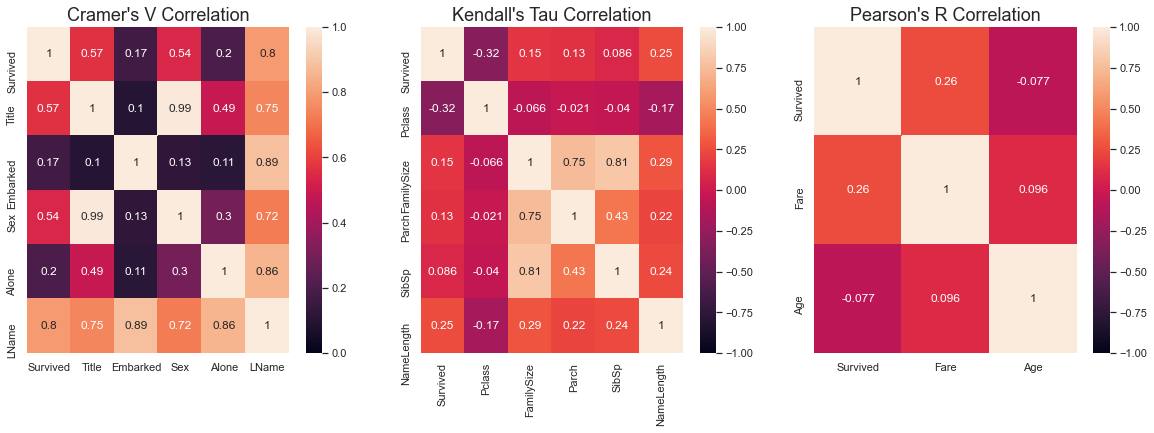

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))

# nominal variable correlation
ax1 = sns.heatmap(cramers_v_matrix(train_df, nom_vars), annot=True, ax=axes[0], vmin=0)

# ordinal variable correlation: 
ax2 = sns.heatmap(train_df[ord_vars].corr(method='kendall'), annot=True, ax=axes[1], vmin=-1)

# Pearson's correlation:
ax3 = sns.heatmap(train_df[cont_vars].corr(), annot=True, ax=axes[2], vmin=-1)

ax1.set_title("Cramer's V Correlation")
ax2.set_title("Kendall's Tau Correlation")
ax3.set_title("Pearson's R Correlation")

The above heatmaps show our strength of association between each variable. While there is no rigid standard for "Highly Associated" or "Weakly Associated", we will use a cut-off value of |0.1| between our independent variables and survival. We will likely drop features whose association is lower than |0.1|. This is an entirely arbitrary guess, and I may return to raise or lower the bar later. 

For now, the features that meet the criteria for dropping are __SibSp__ and __Age__. Additionally, I am choosing to drop __Name__, __Ticket__ and __Cabin__, mostly on a hunch that they don't add much. 


In [19]:
todrop = ['SibSp', 'Ticket', 'Cabin', 'Name']
train_df = train_df.drop(todrop, axis=1)
train_df

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Title,FamilySize,Alone,LName,NameLength
PassengerId,,,,,,,,,,,,
1,0,3,0,22.0,0,7.2500,0,0,2,0,0,23
2,1,1,1,38.0,0,71.2833,1,1,2,0,1,51
3,1,3,1,26.0,0,7.9250,0,2,1,1,2,22
4,1,1,1,35.0,0,53.1000,0,1,2,0,3,44
5,0,3,0,35.0,0,8.0500,0,0,1,1,4,24
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,27.0,0,13.0000,0,5,1,1,663,21
888,1,1,1,19.0,0,30.0000,0,2,1,1,233,28
889,0,3,1,NaN,2,23.4500,0,2,4,0,603,40


# Setup for Machine Learning:

During this phase, we will begin to format our data for feeding into a machine learning algorithm. We will then use this formatted data to get a picture of what a few different models can do for us, and pick the best one. This phase is broken into the following parts:

1. __Train/Test Split__
2. __Normalize Data of each split__ 
3. __Impute missing values__ (None this time. We dropped __Age__ and __Cabin__  which were the only categories missing significant data.)

Let's go.

## Train/Test Split

We will split our data once into training and testing sets. Within the training set, we will use stratified k-fold cross validation to find average performance of our models. 

The test set will not be touched until after we have fully tuned each of our candidate models using the training data and k-fold cross validation. Once training and tuning is complete, we will compare the results of each model on the held-out test set. The one that performs the best will be used for the competition.

In [20]:
X = train_df.drop(['Survived'], axis = 1)
Y = train_df.loc[:, 'Survived']

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=333)

## Normalizing the Data

Some Machine Learning models require all of our predictors to be on the same scale, while others do not. Most notably, models like Logistic Regression and SVM will probably benefit from scaling, while decision trees will simply ignore scaling. Because we are going to be looking at a mixed bag of algorithms, I'm going to go ahead and scale our data.

In [21]:
# We normalize the training and testing data separately so as to avoid data leaks.

x_train = pd.DataFrame(pre.scale(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(pre.scale(x_test), columns=x_test.columns, index=x_test.index)
x_train

,Pclass,Sex,Age,Parch,Fare,Embarked,Title,FamilySize,Alone,LName,NameLength
PassengerId,,,,,,,,,,,
466,0.810433,-0.751555,0.606253,-0.454384,-0.503686,-0.557754,-0.677693,-0.563259,0.802709,0.474261,0.412271
508,-1.624285,-0.751555,NaN,-0.454384,-0.074801,-0.557754,-0.677693,-0.563259,0.802709,0.630255,1.883636
316,0.810433,1.330574,-0.234031,-0.454384,-0.485998,-0.557754,0.974764,-0.563259,0.802709,-0.102915,0.412271
341,-0.406926,-0.751555,-1.914600,0.771076,-0.086898,-0.557754,1.800993,0.749475,-1.245781,-0.830884,0.307174
118,-0.406926,-0.751555,-0.023960,-0.454384,-0.196868,-0.557754,-0.677693,0.093108,-1.245781,-1.324864,0.412271
...,...,...,...,...,...,...,...,...,...,...,...
47,0.810433,-0.751555,NaN,-0.454384,-0.317836,2.631970,-0.677693,0.093108,-1.245781,-1.298865,-1.059093
375,0.810433,1.330574,-1.844576,0.771076,-0.195219,-0.557754,0.974764,2.062208,-1.245781,-1.491257,-0.113216
367,-1.624285,1.330574,2.146774,-0.454384,0.996311,1.037108,0.148535,0.093108,-1.245781,0.084277,2.198929


## Imputing Missing Data

You might recall that there were a significant amount of missing __Age__ values in our data. Let's fill this in with the median age:

In [22]:
x_train.loc[x_train.Age.isnull(), 'Age'] = x_train.loc[:, 'Age'].median()
x_test.loc[x_test.Age.isnull(), 'Age'] = x_test.loc[:, 'Age'].median()
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 466 to 781
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      712 non-null    float64
 1   Sex         712 non-null    float64
 2   Age         712 non-null    float64
 3   Parch       712 non-null    float64
 4   Fare        712 non-null    float64
 5   Embarked    712 non-null    float64
 6   Title       712 non-null    float64
 7   FamilySize  712 non-null    float64
 8   Alone       712 non-null    float64
 9   LName       712 non-null    float64
 10  NameLength  712 non-null    float64
dtypes: float64(11)
memory usage: 66.8 KB


# Model Selection

Now that we have prepared our data, we want to look at different options available to us for solving classification problems. Some common ones are:

- K-Nearest Neighbors
- Support Vector Machines
- Decision Trees
- Logistic Regression

We will train and tune each of these models on our training data by way of k-fold cross-validation. When complete, we will compare the tuned models' performance on a held out test set. 

## Training and Comparing Base Models:

First, we want to get a feel model's performance before tuning. We will write two functions to help us describe our results. The first will evaluate the model several times over random splits in the data, and return the average performance as a dictionary. The second will simply nicely print our dictionary.

In [23]:
def kfold_evaluate(model, folds=5):
    eval_dict = {}
    accuracy = 0
    f1       = 0
    AUC      = 0
    
    skf = model_selection.StratifiedKFold(n_splits=folds)
    
    # perform k splits on the training data. Gather performance results.
    for train_idx, test_idx in skf.split(x_train, y_train):
        xk_train, xk_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
        yk_train, yk_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
        model.fit(xk_train, yk_train)
        y_pred = model.predict(xk_test)
        report = metrics.classification_report(yk_test, y_pred, output_dict=True)
        
        prob_array = model.predict_proba(xk_test)
    
        fpr, tpr, huh = metrics.roc_curve(yk_test, model.predict_proba(xk_test)[:,1])
        auc = metrics.auc(fpr, tpr)
        accuracy   += report['accuracy']
        f1         += report['macro avg']['f1-score']
        AUC        += auc
        
    # Average performance metrics over the k folds
    measures = np.array([accuracy, f1, AUC])
    measures = measures/folds

    # Add metric averages to dictionary and return.
    eval_dict['Accuracy']  = measures[0]
    eval_dict['F1 Score']  = measures[1]
    eval_dict['AUC']       = measures[2]  
    eval_dict['Model']     = model
    
    return eval_dict

# a function to pretty print our dictionary of dictionaries:
def pprint(web, level):
    for k,v in web.items():
        if isinstance(v, dict):
            print('\t'*level, f'{k}: ')
            level += 1
            pprint(v, level)
            level -= 1
        else:
            print('\t'*level, k, ": ", v)

In [24]:
evals = {}
evals['KNN'] = kfold_evaluate(KNeighborsClassifier())
evals['Logistic Regression'] = kfold_evaluate(LogisticRegression(max_iter=1000))
evals['Random Forest'] = kfold_evaluate(RandomForestClassifier())
evals['SVC'] = kfold_evaluate(SVC(probability=True))

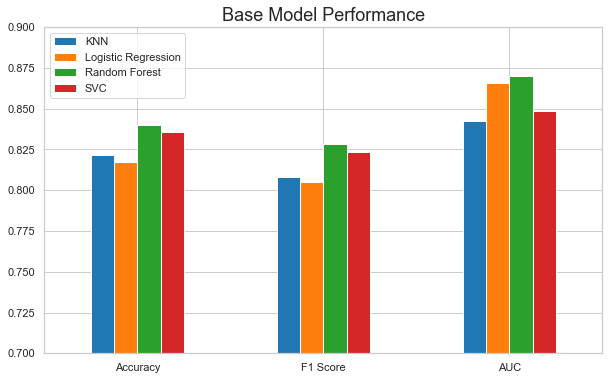

,KNN,Logistic Regression,Random Forest,SVC
Accuracy,0.8216,0.817394,0.8399,0.835625
F1 Score,0.808083,0.805034,0.828417,0.823467
AUC,0.842471,0.865725,0.870281,0.848343
Model,"KNeighborsClassifier(algorithm='auto', leaf_si...","LogisticRegression(C=1.0, class_weight=None, d...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","SVC(C=1.0, break_ties=False, cache_size=200, c..."


In [25]:
result_df = pd.DataFrame(evals)
result_df.drop('Model', axis=0).plot(kind='bar', ylim=(0.7, 0.9)).set_title("Base Model Performance")
plt.xticks(rotation=0)
plt.show()
result_df

### Base Model Summary

It appears that we have a clear winner in our Random Forest classifier.  

## Hyper-parameter Tuning: 

Let's tune up our current champion's hyper-parameters in hopes of eking out a little bit more performance. We will use scikit-learn's `RandomizedSearchCV` which has some speed advantages over using an exhaustive `GridSearchCV`. Our first step is to create our grid of parameters over which we will randomly search for the best settings:

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid, 0)

 n_estimators :  [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
 max_features :  ['auto', 'sqrt']
 max_depth :  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]
 min_samples_split :  [2, 5, 10]
 min_samples_leaf :  [1, 2, 4]
 bootstrap :  [True, False]


Next, we want to create our `RandomizedSearchCV` object which will use the grid we just created above. It will randomly sample 10 combinations of parameters, test them over 3 folds and return the set of parameters that performed the best on our training data.

In [27]:
# create RandomizedSearchCV object
searcher = model_selection.RandomizedSearchCV(estimator = RandomForestClassifier(),
                                            param_distributions = random_grid,
                                            n_iter = 10, # Number of parameter settings to sample (this could take a while)
                                            cv     = 3,  # Number of folds for k-fold validation 
                                            n_jobs = -1, # Use all processors to compute in parallel
                                            random_state=0) 
search = searcher.fit(x_train, y_train)

In [28]:
params = search.best_params_
params

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

After performing our parameter tuning, we can verify whether or not the parameters provided by the search actually improve the base model or not. Let's compare the performance of the two models before and after tuning.

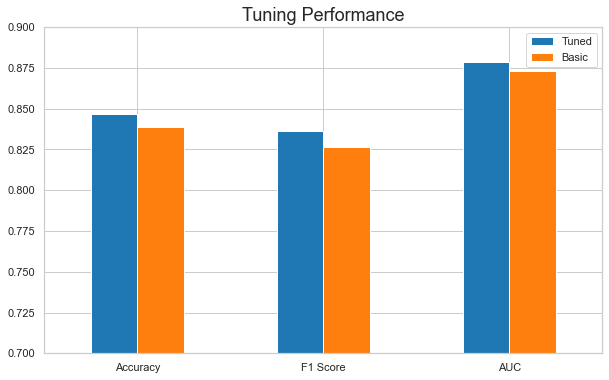

,Tuned,Basic
Accuracy,0.846902,0.838501
F1 Score,0.836075,0.826364
AUC,0.878691,0.872901
Model,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


In [29]:
tuning_eval = {}
tuned_rf = RandomForestClassifier(**params)
basic_rf = RandomForestClassifier()

tuning_eval['Tuned'] = kfold_evaluate(tuned_rf)
tuning_eval['Basic'] = kfold_evaluate(basic_rf)

result_df = pd.DataFrame(tuning_eval)
result_df.drop('Model', axis=0).plot(kind='bar', ylim=(0.7, 0.9)).set_title("Tuning Performance")
plt.xticks(rotation=0)
plt.show()
result_df

# Final Steps: 

Now that we have chosen and tuned a Random Forest classifier, we want to test it on data it has never before seen.  This will tell us how we might expect the model to perform in the future, on new data. It's time to use that held out test set. 

Then, we will combine the test and training data, and re-fit our model to the combined data set, hopefully giving it the greatest chance of success on the unlabeled data from the competition. 

Finally, we will make our predictions on the unlabeled data for submission to the competition. 

### Final Test on Held Out Data

In [30]:
y_pred = tuned_rf.predict(x_test)

In [31]:
results = metrics.classification_report(y_test, y_pred,
                                        labels = [0, 1],
                                        target_names = ['Died', 'Survived'],
                                        output_dict = True)

pprint(results, 0)

 Died: 
	 precision :  0.7815126050420168
	 recall :  0.8532110091743119
	 f1-score :  0.8157894736842106
	 support :  109
 Survived: 
	 precision :  0.7333333333333333
	 recall :  0.6285714285714286
	 f1-score :  0.6769230769230768
	 support :  70
 accuracy :  0.7653631284916201
 macro avg: 
	 precision :  0.757422969187675
	 recall :  0.7408912188728702
	 f1-score :  0.7463562753036437
	 support :  179
 weighted avg: 
	 precision :  0.7626715490665541
	 recall :  0.7653631284916201
	 f1-score :  0.761484178861421
	 support :  179


It looks like we may have experienced some overfitting. Our model's performance on the test data is roughly 7-9% lower across the board. 

### Combine Training and Testing Datasets for Final Model Fit

Now that we have ascertained that our tuned model performs with about 76% accuracy and has an f1-score of 0.74 on new data, we can proceed to train our model on the entire labeled training set. 

In [32]:
X = pd.concat([x_train, x_test], axis=0).sort_index()
Y = pd.concat([y_train, y_test], axis=0).sort_index()
tuned_rf.fit(X, Y)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Format and Standardize Unlabeled Data

Next we need to transform our unlabeled data in the same manner as when we were formatting our training data. This includes encoding categorical variables, dropping the same features and normalization. This should ensure consistent results on the never before seen competition data. 

In [33]:
# Feature Engineering:
test_df['Title'] = test_df.Name.str.extract(r'([A-Za-z]+)\.')
test_df['LName'] = test_df.Name.str.extract(r'([A-Za-z]+),')
test_df['NameLength'] = test_df.Name.apply(len)
test_df['FamilySize'] = 1 + test_df.SibSp + test_df.Parch
test_df['Alone'] = test_df.FamilySize.apply(lambda x: 1 if x==1 else 0)
test_df.Title = test_df.Title.map(title_dict)

# Feature Selection
test_df = test_df.drop(todrop, axis=1)

# Imputation of missing age and fare data
test_df.loc[test_df.Age.isna(), 'Age'] = test_df.Age.median()
test_df.loc[test_df.Fare.isna(), 'Fare'] = test_df.Fare.median()

# encode categorical data
for i in test_df.columns:
    if test_df[i].dtype == 'object':
        test_df[i], _ = pd.factorize(test_df[i])
        
# center and scale data 
test_df = pd.DataFrame(pre.scale(test_df), columns=test_df.columns, index=test_df.index)

# ensure columns of unlabeled data are in same order as training data.
test_df = test_df[x_test.columns]
test_df

,Pclass,Sex,Age,Parch,Fare,Embarked,Title,FamilySize,Alone,LName,NameLength
PassengerId,,,,,,,,,,,
892,0.873482,-0.755929,0.386231,-0.400248,-0.497413,-1.955941,-0.713830,-0.553443,0.807573,-1.672873,-1.153019
893,0.873482,1.322876,1.371370,-0.400248,-0.512278,-0.231082,0.207099,0.105643,-1.238278,-1.662873,0.453521
894,-0.315819,-0.755929,2.553537,-0.400248,-0.464100,-1.955941,-0.713830,-0.553443,0.807573,-1.652873,-0.249340
895,0.873482,-0.755929,-0.204852,-0.400248,-0.482475,-0.231082,-0.713830,-0.553443,0.807573,-1.642873,-1.153019
896,0.873482,1.322876,-0.598908,0.619896,-0.417492,-0.231082,0.207099,0.764728,-1.238278,-1.632872,1.658426
...,...,...,...,...,...,...,...,...,...,...,...
1305,0.873482,-0.755929,-0.204852,-0.400248,-0.493455,-0.231082,-0.713830,-0.553443,0.807573,1.797181,-0.952201
1306,-1.505120,1.322876,0.740881,-0.400248,1.314435,1.493778,5.732668,-0.553443,0.807573,1.807181,0.051886
1307,0.873482,-0.755929,0.701476,-0.400248,-0.507796,-0.231082,-0.713830,-0.553443,0.807573,1.817182,0.051886


### Make Final Predictions

Roughly 32 percent of the passengers aboard the Titanic lived. We will do a last, common sense check to see if our algorithm predicts roughly the same distribution of survivals. Since __Survived__ variable with value 1 implies survival, we can simply 

In [34]:
final = tuned_rf.predict(test_df)

In [35]:
final.sum()/len(final)

0.3660287081339713

In [36]:
submission = pd.DataFrame({'PassengerId':test_df.index,
                           'Survived':final})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [37]:
submission.to_csv('submission2.csv', index=False)